# Notebook for demonstrating the use of beeswarms for CIU (and other) visualisation.

Basic imports.

In [1]:
#!pip3 install xgboost
#!pip3 install plotly
#%pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
import ciu as ciu
from ciu import ciuplots

## Boston housing

Start by loading the data and training a GB model on it. 

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
boston_target = raw_df.values[1::2, 2]

boston_data = pd.DataFrame(data)
boston_data.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
np.random.seed(26) # We want to always get the same train/test sets and model here.
X_train, X_test, y_train, y_test = train_test_split(boston_data, boston_target, test_size=0.3, random_state=123)
boston_xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
boston_xgb_model.fit(X_train,y_train)


XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

Then create CIU object and get CIU values for all the instances of interest. For the whole dataset this will typically take over a minute. 

The initialisation of the out_minmaxs DataFrame is needed because Boston is a regresion task and we need to map the output value `Price` into a corresponding utility value. 

The parameter `do_norm_invals` is set to `True` because we want to get normalized input values for the beeswarm plot. 

In [3]:
out_minmaxs = pd.DataFrame({'mins': [min(y_train)], 'maxs': max(y_train)})
CIU = ciu.CIU(boston_xgb_model.predict, ['Price'], data=X_train, out_minmaxs=out_minmaxs)
CIUres = CIU.explain_all(X_test, do_norm_invals=True)
display(CIUres)

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs,instance_name,norm_invals
0,0.017942,0.000000,-0.008971,Price,19.113840,CRIM,19.113840,19.921244,[0],[51.1358],0.5,None,None,410,0.574651
1,0.027332,0.000000,-0.013666,Price,19.113840,ZN,19.113840,20.343763,[1],[0.0],0.5,None,None,410,0.0
2,0.053155,0.000000,-0.026577,Price,19.113840,INDUS,19.113840,21.505812,[2],[18.1],0.5,None,None,410,0.646628
3,0.000000,0.000000,-0.000000,Price,19.113840,CHAS,19.113840,19.113840,[3],[0.0],0.5,None,None,410,0.0
4,0.048834,0.342554,-0.007689,Price,19.113840,NOX,18.361063,20.558607,[4],[0.597],0.5,None,None,410,0.427975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,0.000000,0.000000,-0.000000,Price,21.273912,RAD,21.273912,21.273912,[8],[24.0],0.5,None,None,472,1.0
1972,0.025795,0.167980,-0.008564,Price,21.273912,TAX,21.078928,22.239691,[9],[666.0],0.5,None,None,472,0.914122
1973,0.045318,0.000000,-0.022659,Price,21.273912,PTRATIO,21.273912,23.313242,[10],[20.2],0.5,None,None,472,0.808511
1974,0.037479,0.505925,0.000222,Price,21.273912,B,20.420645,22.107193,[11],[393.37],0.5,None,None,472,0.991099


Then we can plot the beeswarm. We start by the default parameters, which plots CI values. 

In [4]:
fig = ciuplots.ciu_beeswarm(CIUres, legend_title='Value scale')
fig.update_layout(height=600, width=900, margin=dict(l=20, r=20, t=50, b=20))
fig.update_layout(
    title='CI versus input value for all features',
    xaxis=dict(title='Contextual Importance (CI)'),
    yaxis=dict(title='Feature'),
)
fig.show()



We can also plot Contextual influence values, which will give us something that looks quite similar to the SHAP beeswarm, or to the R-CIU beeswarm.

In [5]:
fig = ciuplots.ciu_beeswarm(CIUres, xcol='Cinfl', legend_title='Value scale')
fig.update_layout(height=600, width=900, margin=dict(l=20, r=20, t=20, b=20), xaxis=dict(title='Contextual influence'))
fig.show()

We can see from the influnce plot that a high `lstat` value is bad and a low one is good, for instance. 

If we plot CU values, this might become even clearer.

In [6]:
fig = ciuplots.ciu_beeswarm(CIUres, xcol='CU', legend_title='Value scale')
fig.update_layout(height=600, width=900, margin=dict(l=20, r=20, t=20, b=20), xaxis=dict(title='Contextual Utility (CU)'))
fig.show()

## From here on old, obsolete tests

It seems difficult to find a library that would produce "true" beeswarm plots in the desired way. The rest of the notebook contains different tests performed that might turn out to be useful with more insight into the plotting functionality of the libraries and plot types. 

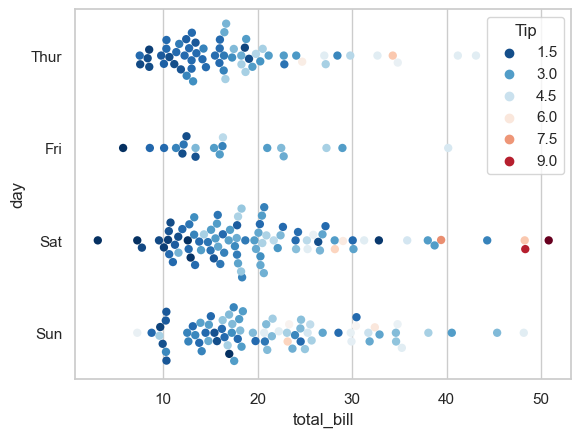

In [7]:
# Sample data
tips = sns.load_dataset("tips")

# Create a beeswarm plot using seaborn
sns.set(style="whitegrid")
sns.swarmplot(x="total_bill", y="day", data=tips, hue="tip", palette="RdBu_r", size=6)

# Set legend outside the plot
plt.legend(title="Tip", loc=0)#bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

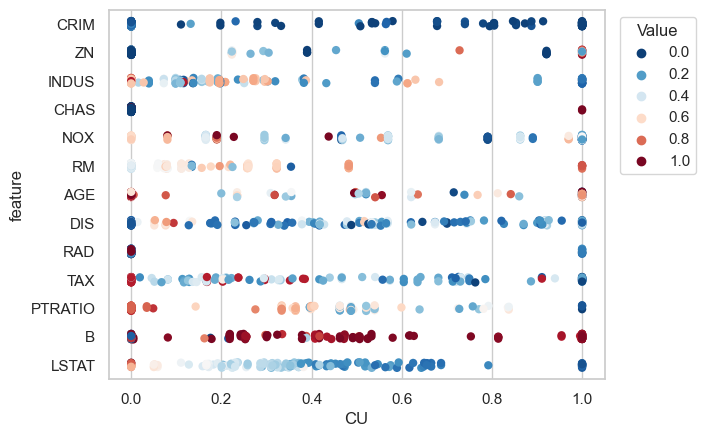

In [8]:
#fig, ax = plt.subplots(figsize=(10,8))
sns.set(style="whitegrid")
#color_palette = sns.color_palette("RdBu_r", n_colors=100)
#sns.stripplot(x="CI", y="feature", data=df, hue="invals", palette="RdBu_r", size=6, jitter=0.3)
#sns.swarmplot(x="CI", y="feature", data=df, hue="invals", palette="RdBu_r", dodge=True, size=6)
sns.stripplot(x="CU", y="feature", data=CIUres, hue="norm_invals", palette="RdBu_r", size=6)

# Set legend outside the plot
plt.legend(title="Value", loc=1, bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

In [9]:
#%pip install --upgrade pip
#%pip install nbformat
#%pip install plotly
import plotly.graph_objects as go
import seaborn as sns

# Sample data
tips = sns.load_dataset("tips")

palette = ["blue", "red"]

# Create a beeswarm plot using Plotly
fig = go.Figure()

# Add a box plot to serve as the background
#fig.add_trace(go.Box(x=tips['day'], y=tips['total_bill'], boxpoints='all', jitter=0.3, pointpos=-1.8))
#fig.add_trace(go.Box(x=df.loc[:,'CI'], y=df.loc[:,'feature'], boxpoints='all', jitter=0.3, pointpos=-1.8))

# Add individual data points with a scatter plot
fig.add_trace(go.Scatter(
    # x=tips['day'],
    # y=tips['total_bill'],
    x=CIUres.loc[:,'CI'],
    y=CIUres.loc[:,'feature'],
    mode='markers',
    marker=dict(
        size=9,
        color=CIUres['norm_invals'],
        colorscale=palette,
        colorbar=dict(
            title='Norm.Value',
        ),
    ),
    showlegend=False  # Hide legend for individual data points
))

# Update layout for better visibility
fig.update_layout(
    title='Beeswarm Plot with Plotly',
    xaxis=dict(title='Day'),
    yaxis=dict(title='Total Bill'),
)

# Show the plot
fig.show()


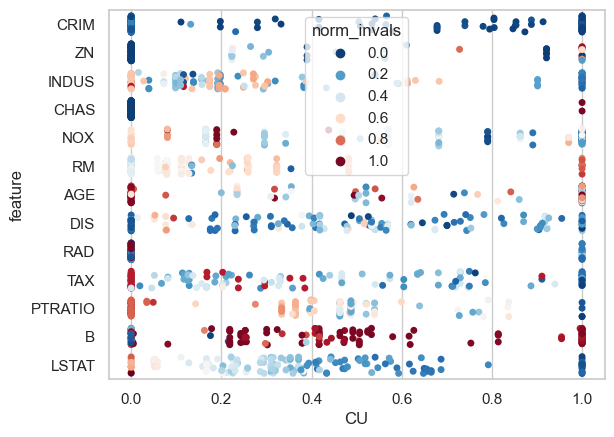

In [10]:
import seaborn as sns

# Sample data
tips = sns.load_dataset("tips")

#custom_palette = sns.color_palette("coolwarm", as_cmap=True)

#sns.heatmap([[0, 1]], cmap=custom_palette, cbar=True, linewidths=0)
#ax = sns.stripplot(x=tips['total_bill'], y=tips['day'], hue=tips['tip'], jitter=0.3, palette="RdBu_r")
ax = sns.stripplot(data=CIUres, x='CU', y='feature', hue='norm_invals', jitter=0.3, palette="RdBu_r")#cmap=custom_palette, cbar=True)#, palette=custom_palette)

# Show the plot
plt.show()


In [11]:
import plotly.express as px
import seaborn as sns

# Sample data
tips = sns.load_dataset("tips")

# https://community.plotly.com/t/shap-like-bee-swarm-plots/68015/2

# Create a beeswarm plot using Plotly Express
#fig = px.strip(tips, x='total_bill', y='day', color='tip', stripmode='overlay', height=400, width=500)
fig = px.strip(CIUres, x='CI', y='feature', color='norm_invals', stripmode='overlay', height=600, width=500)

# Update layout for better visibility
fig.update_layout(
    title='Beeswarm Plot with Plotly Express',
    xaxis=dict(title='Day'),
    yaxis=dict(title='Total Bill'),
    height=800, 
    width=800
)
fig.update_layout(xaxis=dict(showgrid=True, gridcolor='WhiteSmoke', zerolinecolor='Gainsboro'),
              yaxis=dict(showgrid=True, gridcolor='WhiteSmoke', zerolinecolor='Gainsboro')
)
fig.update_layout(plot_bgcolor='white')

fig = (
    fig
    # Make it so there is no gap between the supporting boxes
    .update_layout(boxgap=0)
    # Increase the jitter so it reaches the sides of the boxes
    .update_traces(jitter=1)
)

# Show the plot
fig.show()
